## **Mount implementation folder in google drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%cd /content/drive/MyDrive/FYP/Implementation/data
! ls

/content/drive/.shortcut-targets-by-id/1MkC_V0CRXkQ-OsCBxF38m1Sku4w4s3TR/FYP/Implementation/data
encoded-data.csv	preprosessing-dos.csv	  UNSW-NB15_1.csv
NUSW-NB15_features.csv	selected_columns_all.csv  UNSW-NB15_2.csv
OTset.csv		SVR-predict-data.csv	  UNSW-NB15_3.csv
preprocessing.csv	testset.csv		  UNSW-NB15_4.csv


## **Load balanced training datset for DOS attacks**

Data = (x_train, y_train)

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle

#get select columns for training
select_col=pd.read_csv("selected_columns_all.csv", sep=',', on_bad_lines='skip', index_col=False)
columns=list(select_col['Backdoors'])


#create training dataset down sampling
df = pd.read_csv('encoded-data.csv', sep=',', on_bad_lines='skip', index_col=False)
attack_labels = ['Analysis', 'Backdoors', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Reconnaissance', 'Shellcode', 'Worms'] + ['attack_cat','Label']


DoS_attacks = df[df['Backdoors'] == 1]
Normal_Data = df[df['Label'] == 0]
frames = [DoS_attacks, Normal_Data]
result = pd.concat(frames)
X=result.drop(labels=attack_labels, axis=1)
Y=result[['Backdoors']]
X.head()

undersample = RandomUnderSampler(random_state=0)
# fit and apply the transform
X, Y = undersample.fit_resample(X,Y)


x_train,y_train  = shuffle(X[columns],Y)


X_train_normalized = preprocessing.normalize(x_train)
X_train_normalized 




array([[1.67742868e-02, 3.32823151e-04, 1.69074161e-02, ...,
        8.88738376e-01, 4.53172003e-01, 5.96419087e-02],
       [0.00000000e+00, 1.13636364e-08, 1.13636364e-07, ...,
        1.00000000e+00, 5.00000000e-07, 0.00000000e+00],
       [0.00000000e+00, 6.75000007e-08, 2.85750003e-06, ...,
        1.00000000e+00, 2.25000002e-06, 0.00000000e+00],
       ...,
       [9.62785324e-05, 1.65997470e-05, 1.02918431e-04, ...,
        9.99557913e-01, 2.96405082e-02, 1.75957318e-04],
       [0.00000000e+00, 6.00000000e-08, 2.54000000e-06, ...,
        1.00000000e+00, 2.00000000e-06, 0.00000000e+00],
       [2.69392650e-05, 4.64470086e-06, 2.87971453e-05, ...,
        9.99996548e-01, 2.55458547e-03, 5.51790462e-04]])

## **Create Test Set for DOS attacks**

Data = (x_test_DOS_normalized, y_test)

In [5]:
import pandas as pd
import numpy as np
select_col=pd.read_csv("selected_columns_all.csv", sep=',', on_bad_lines='skip', index_col=False)

columns=list(select_col['Backdoors'])

test_data =pd.read_csv("testset.csv", sep=',', on_bad_lines='skip', index_col=False)
attack_labels = ['Analysis', 'Backdoors', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Reconnaissance', 'Shellcode', 'Worms'] + ['attack_cat','Label']
attack_categories = ['Analysis', 'Backdoors', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Reconnaissance', 'Shellcode', 'Worms'] 

DoS_attacks = test_data[test_data['attack_cat'] == 'Backdoors']
# print(DoS_attacks.shape)
Normal_Data = test_data[test_data['Label'] == 0]
# print(Normal_Data.shape)

frames = [DoS_attacks, Normal_Data]
result = pd.concat(frames)
X=result.drop(labels=['attack_cat', 'Label'], axis=1)
Y=result[['Label']]
X.head()

x_test,y_test  = shuffle(X[columns],Y)

x_test = x_test.replace('-','')
x_test = x_test.replace(r'^\s*$', np.nan, regex=True)

#delete raws with missing values
for i in x_test.columns.values.tolist():
  i = x_test.loc[x_test[i].isnull()].index
  x_test = x_test.drop(index=list(i))
  y_test = y_test.drop(index=list(i))

percent_missing = x_test.isnull().sum()
missing_value_df = pd.DataFrame({'column_name': x_test.columns, 'count_missing': percent_missing, 'To be dropped': (percent_missing > 45)})
# print(missing_value_df)

x_test.head()
#encode the data
from sklearn.preprocessing import LabelEncoder

# replace hex with int
# x_test['sport'] = x_test['sport'].astype(str).apply(int, base=16)
# x_test['dsport'] = x_test['dsport'].astype(str).apply(int, base=16)

# #Create an instance of Label-encoder
labelencoder = LabelEncoder() 

# # encode columns consists with strings
x_test['srcip'] = labelencoder.fit_transform(x_test['srcip'])
x_test['dstip'] = labelencoder.fit_transform(x_test['dstip'])
x_test['proto'] = labelencoder.fit_transform(x_test['proto'])
x_test['state'] = labelencoder.fit_transform(x_test['state'])

X_test_normalized = preprocessing.normalize(x_test) 


**Random Forrest Regression**

In [6]:
# Fitting Random Forest Regression to the dataset
# import the regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

#training data
x = np.array(X_train_normalized)
y = np.array(y_train)


# Number of trees in random forest
n_estimators = [2, 4, 8, 16, 32, 64, 100]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2,4]
# Minimum number of samples required to split a node
min_samples_split = [2,3, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}




 # create regressor object
regressor = GridSearchCV(RandomForestRegressor(random_state=0),param_grid,cv=10,return_train_score=False)

# fit the regressor with x and y data
regressor.fit(x, y)


df = pd.DataFrame(regressor.cv_results_)
df

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConv

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.009165,0.002484,0.000782,0.000104,True,2,auto,1,2,2,...,0.914788,0.847116,0.877711,0.843330,0.874796,0.854209,0.890905,0.870288,0.022111,205
1,0.015043,0.000925,0.000885,0.000125,True,2,auto,1,2,4,...,0.900503,0.871884,0.872025,0.876209,0.888466,0.867188,0.878539,0.877544,0.013457,183
2,0.027921,0.000979,0.001151,0.000097,True,2,auto,1,2,8,...,0.904113,0.874465,0.859756,0.876161,0.888607,0.866879,0.877114,0.877689,0.013625,175
3,0.056043,0.002469,0.001794,0.000323,True,2,auto,1,2,16,...,0.902650,0.879141,0.857484,0.871316,0.886314,0.869418,0.883256,0.878709,0.013807,143
4,0.109881,0.003655,0.002729,0.000312,True,2,auto,1,2,32,...,0.905449,0.879195,0.861539,0.874699,0.886552,0.868615,0.880413,0.879122,0.014502,136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,0.018102,0.001764,0.001139,0.000160,False,4,sqrt,2,5,8,...,0.902556,0.900664,0.890887,0.885318,0.897657,0.884132,0.887968,0.890763,0.009189,105
332,0.035960,0.003385,0.001692,0.000145,False,4,sqrt,2,5,16,...,0.890982,0.892648,0.871914,0.881870,0.903309,0.870375,0.875502,0.884988,0.011002,121
333,0.068975,0.001635,0.003128,0.000667,False,4,sqrt,2,5,32,...,0.878020,0.888426,0.863528,0.875047,0.896229,0.854424,0.879306,0.878736,0.012880,142
334,0.138767,0.005083,0.004785,0.000212,False,4,sqrt,2,5,64,...,0.881825,0.887753,0.866535,0.867140,0.892966,0.862196,0.871292,0.877766,0.010865,172


In [7]:
df[['param_bootstrap', 	'param_max_depth', 	'param_max_features', 	'param_min_samples_leaf', 	'param_min_samples_split', 	'param_n_estimators','mean_test_score']]

,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_test_score
0,True,2,auto,1,2,2,0.870288
1,True,2,auto,1,2,4,0.877544
2,True,2,auto,1,2,8,0.877689
3,True,2,auto,1,2,16,0.878709
4,True,2,auto,1,2,32,0.879122
...,...,...,...,...,...,...,...
331,False,4,sqrt,2,5,8,0.890763
332,False,4,sqrt,2,5,16,0.884988
333,False,4,sqrt,2,5,32,0.878736
334,False,4,sqrt,2,5,64,0.877766


In [8]:
regressor.best_params_

{'bootstrap': True,
 'max_depth': 4,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

**Train the model**

In [9]:
from sklearn.ensemble import RandomForestRegressor

#training data
x = np.array(X_train_normalized)
y = np.array(y_train)


 # create regressor object
regressor = RandomForestRegressor(bootstrap=True,max_depth=4,max_features= 'auto',min_samples_leaf=1,min_samples_split=2,n_estimators=100)

# fit the regressor with x and y data
regressor.fit(x, y)

y_pred = regressor.predict(x)


<ipython-input-9-1353b2312a02>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor.fit(x, y)


In [10]:
from sklearn.metrics import accuracy_score

for i in range(1,100):
  y_predict_class = [1 if p > i/100 else 0 for p in y_pred]
  print("Accuracy when threshould = ",i/100, round(accuracy_score(y, y_predict_class), 6))

Accuracy when threshould =  0.01 0.937048
Accuracy when threshould =  0.02 0.93958
Accuracy when threshould =  0.03 0.940304
Accuracy when threshould =  0.04 0.969971
Accuracy when threshould =  0.05 0.970333
Accuracy when threshould =  0.06 0.975398
Accuracy when threshould =  0.07 0.976122
Accuracy when threshould =  0.08 0.976845
Accuracy when threshould =  0.09 0.977207
Accuracy when threshould =  0.1 0.976845
Accuracy when threshould =  0.11 0.976845
Accuracy when threshould =  0.12 0.985166
Accuracy when threshould =  0.13 0.98589
Accuracy when threshould =  0.14 0.986252
Accuracy when threshould =  0.15 0.98589
Accuracy when threshould =  0.16 0.98589
Accuracy when threshould =  0.17 0.986252
Accuracy when threshould =  0.18 0.98589
Accuracy when threshould =  0.19 0.986252
Accuracy when threshould =  0.2 0.986975
Accuracy when threshould =  0.21 0.986975
Accuracy when threshould =  0.22 0.986975
Accuracy when threshould =  0.23 0.986975
Accuracy when threshould =  0.24 0.986975

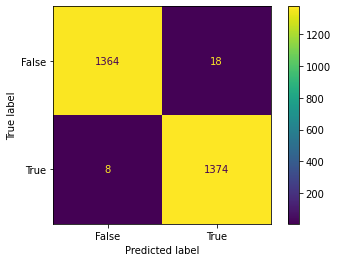

In [11]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

threshould =0.5

y_predict_class = [1 if p > threshould else 0 for p in y_pred]
confusion_matrix = metrics.confusion_matrix(y, y_predict_class)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show() 


**Test Set Accuracy**

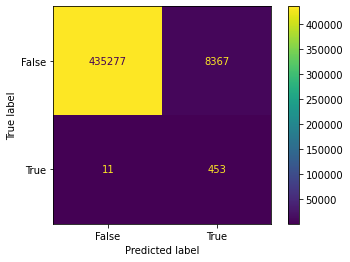

Accuracy when threshould =  0.6 0.981135


In [12]:
x_test_array = np.array(X_test_normalized)
y_test_array = np.array(y_test)
y_pred_test_set = regressor.predict(x_test_array)


threshould =0.6


y_predict_test_set_class = [1 if p > threshould else 0 for p in y_pred_test_set]
confusion_matrix = metrics.confusion_matrix(y_test_array, y_predict_test_set_class)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show() 

print("Accuracy when threshould = ",threshould, round(accuracy_score(y_test_array, y_predict_test_set_class), 6))